Using device: cuda
Loading model: microsoft/Phi-3-mini-4k-instruct


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model has 32 decoder blocks
Loading SQuAD (train)...
Dataset size after filtering/select: 200 rows

Sample prompt:
<|user|>
Question: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
Context: Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is   ...

Starting per-layer effort computation (Phi-3 style) ...


100%|██████████| 100/100 [13:56<00:00,  8.37s/it]



--- Per-layer squared gradient norms (mean over batches) [Phi-3] ---
Layer  1:  1.780139e+03
Layer  2:  6.618098e+03
Layer  3:  1.811583e+03
Layer  4:  5.764958e+02
Layer  5:  5.157722e+02
Layer  6:  5.318145e+02
Layer  7:  3.697520e+02
Layer  8:  2.756953e+02
Layer  9:  2.107834e+02
Layer 10:  2.624000e+02
Layer 11:  2.388631e+02
Layer 12:  2.116299e+02
Layer 13:  1.815367e+02
Layer 14:  1.456988e+02
Layer 15:  1.622464e+02
Layer 16:  1.382057e+02
Layer 17:  1.025645e+02
Layer 18:  1.340766e+02
Layer 19:  1.399159e+02
Layer 20:  1.130791e+02
Layer 21:  8.365781e+01
Layer 22:  7.642461e+01
Layer 23:  1.499671e+02
Layer 24:  8.548838e+01
Layer 25:  8.940000e+01
Layer 26:  3.851928e+01
Layer 27:  2.847045e+01
Layer 28:  3.036609e+01
Layer 29:  3.579445e+01
Layer 30:  2.448543e+01
Layer 31:  4.767391e+00
Layer 32:  6.351813e+00


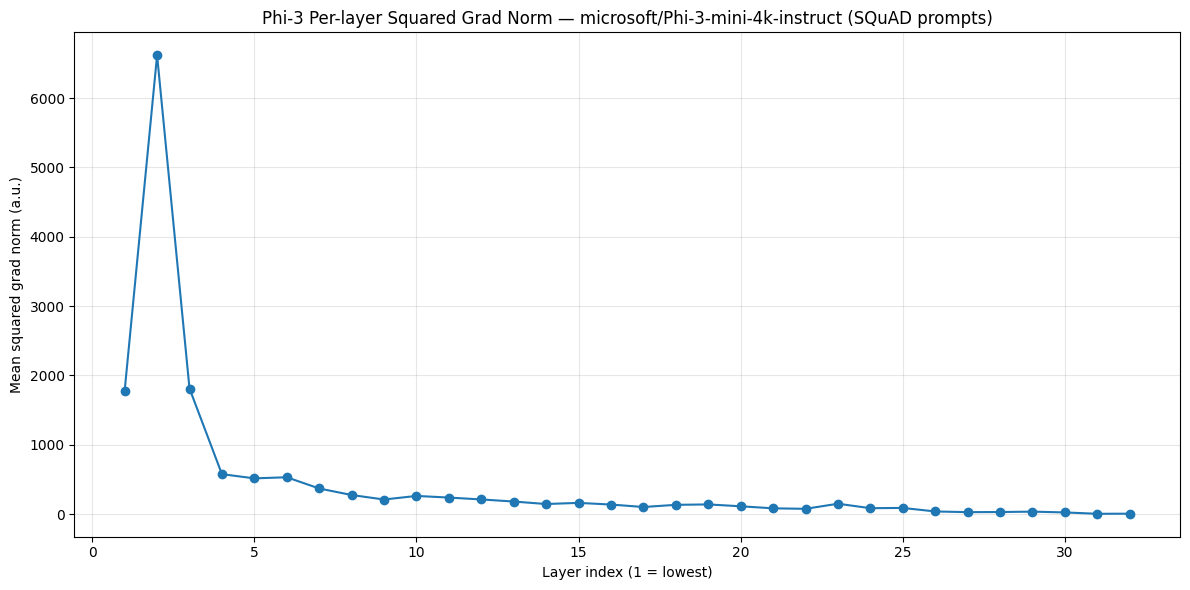


Computing Thermodynamic Length from predictions (Fisher–Rao, exact) ...


100%|██████████| 100/100 [04:48<00:00,  2.89s/it]



--- Fisher–Rao Thermodynamic Length from predictions (per inter-layer step) ---
Between layers  1 and  2: 1.555089e+00 rad
Between layers  2 and  3: 1.624146e+00 rad
Between layers  3 and  4: 1.366538e+00 rad
Between layers  4 and  5: 1.379072e+00 rad
Between layers  5 and  6: 1.338701e+00 rad
Between layers  6 and  7: 1.401642e+00 rad
Between layers  7 and  8: 1.486728e+00 rad
Between layers  8 and  9: 1.386769e+00 rad
Between layers  9 and 10: 1.343663e+00 rad
Between layers 10 and 11: 1.277846e+00 rad
Between layers 11 and 12: 1.264432e+00 rad
Between layers 12 and 13: 1.176652e+00 rad
Between layers 13 and 14: 1.127180e+00 rad
Between layers 14 and 15: 1.123370e+00 rad
Between layers 15 and 16: 1.094504e+00 rad
Between layers 16 and 17: 1.090572e+00 rad
Between layers 17 and 18: 1.180304e+00 rad
Between layers 18 and 19: 1.108654e+00 rad
Between layers 19 and 20: 1.001612e+00 rad
Between layers 20 and 21: 9.895057e-01 rad
Between layers 21 and 22: 9.195257e-01 rad
Between layers 2

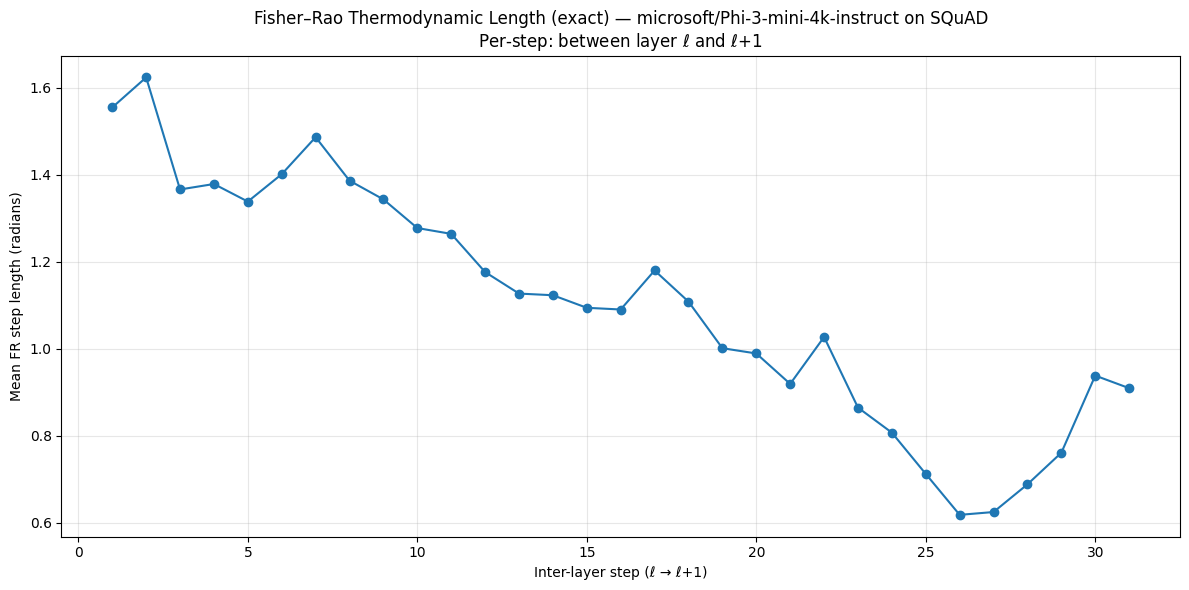


--- Final Metrics (Phi-3) ---
Layer |   Param Strain (E_l) |   Belief Change (Δp_l) |  Semantic Efficiency (L_eff)
-------------------------------------------------------------------------------------
    1 |           1.7801e+03 |           1.555089e+00 |                       1.4972
    2 |           6.6181e+03 |           1.624146e+00 |                       0.6931
    3 |           1.8116e+03 |           1.366538e+00 |                       1.3144
    4 |           5.7650e+02 |           1.379072e+00 |                       2.2771
    5 |           5.1577e+02 |           1.338701e+00 |                       2.3291
    6 |           5.3181e+02 |           1.401642e+00 |                       2.3769
    7 |           3.6975e+02 |           1.486728e+00 |                       2.8120
    8 |           2.7570e+02 |           1.386769e+00 |                       2.9780
    9 |           2.1078e+02 |           1.343663e+00 |                       3.1842
   10 |           2.6240e+02 |   

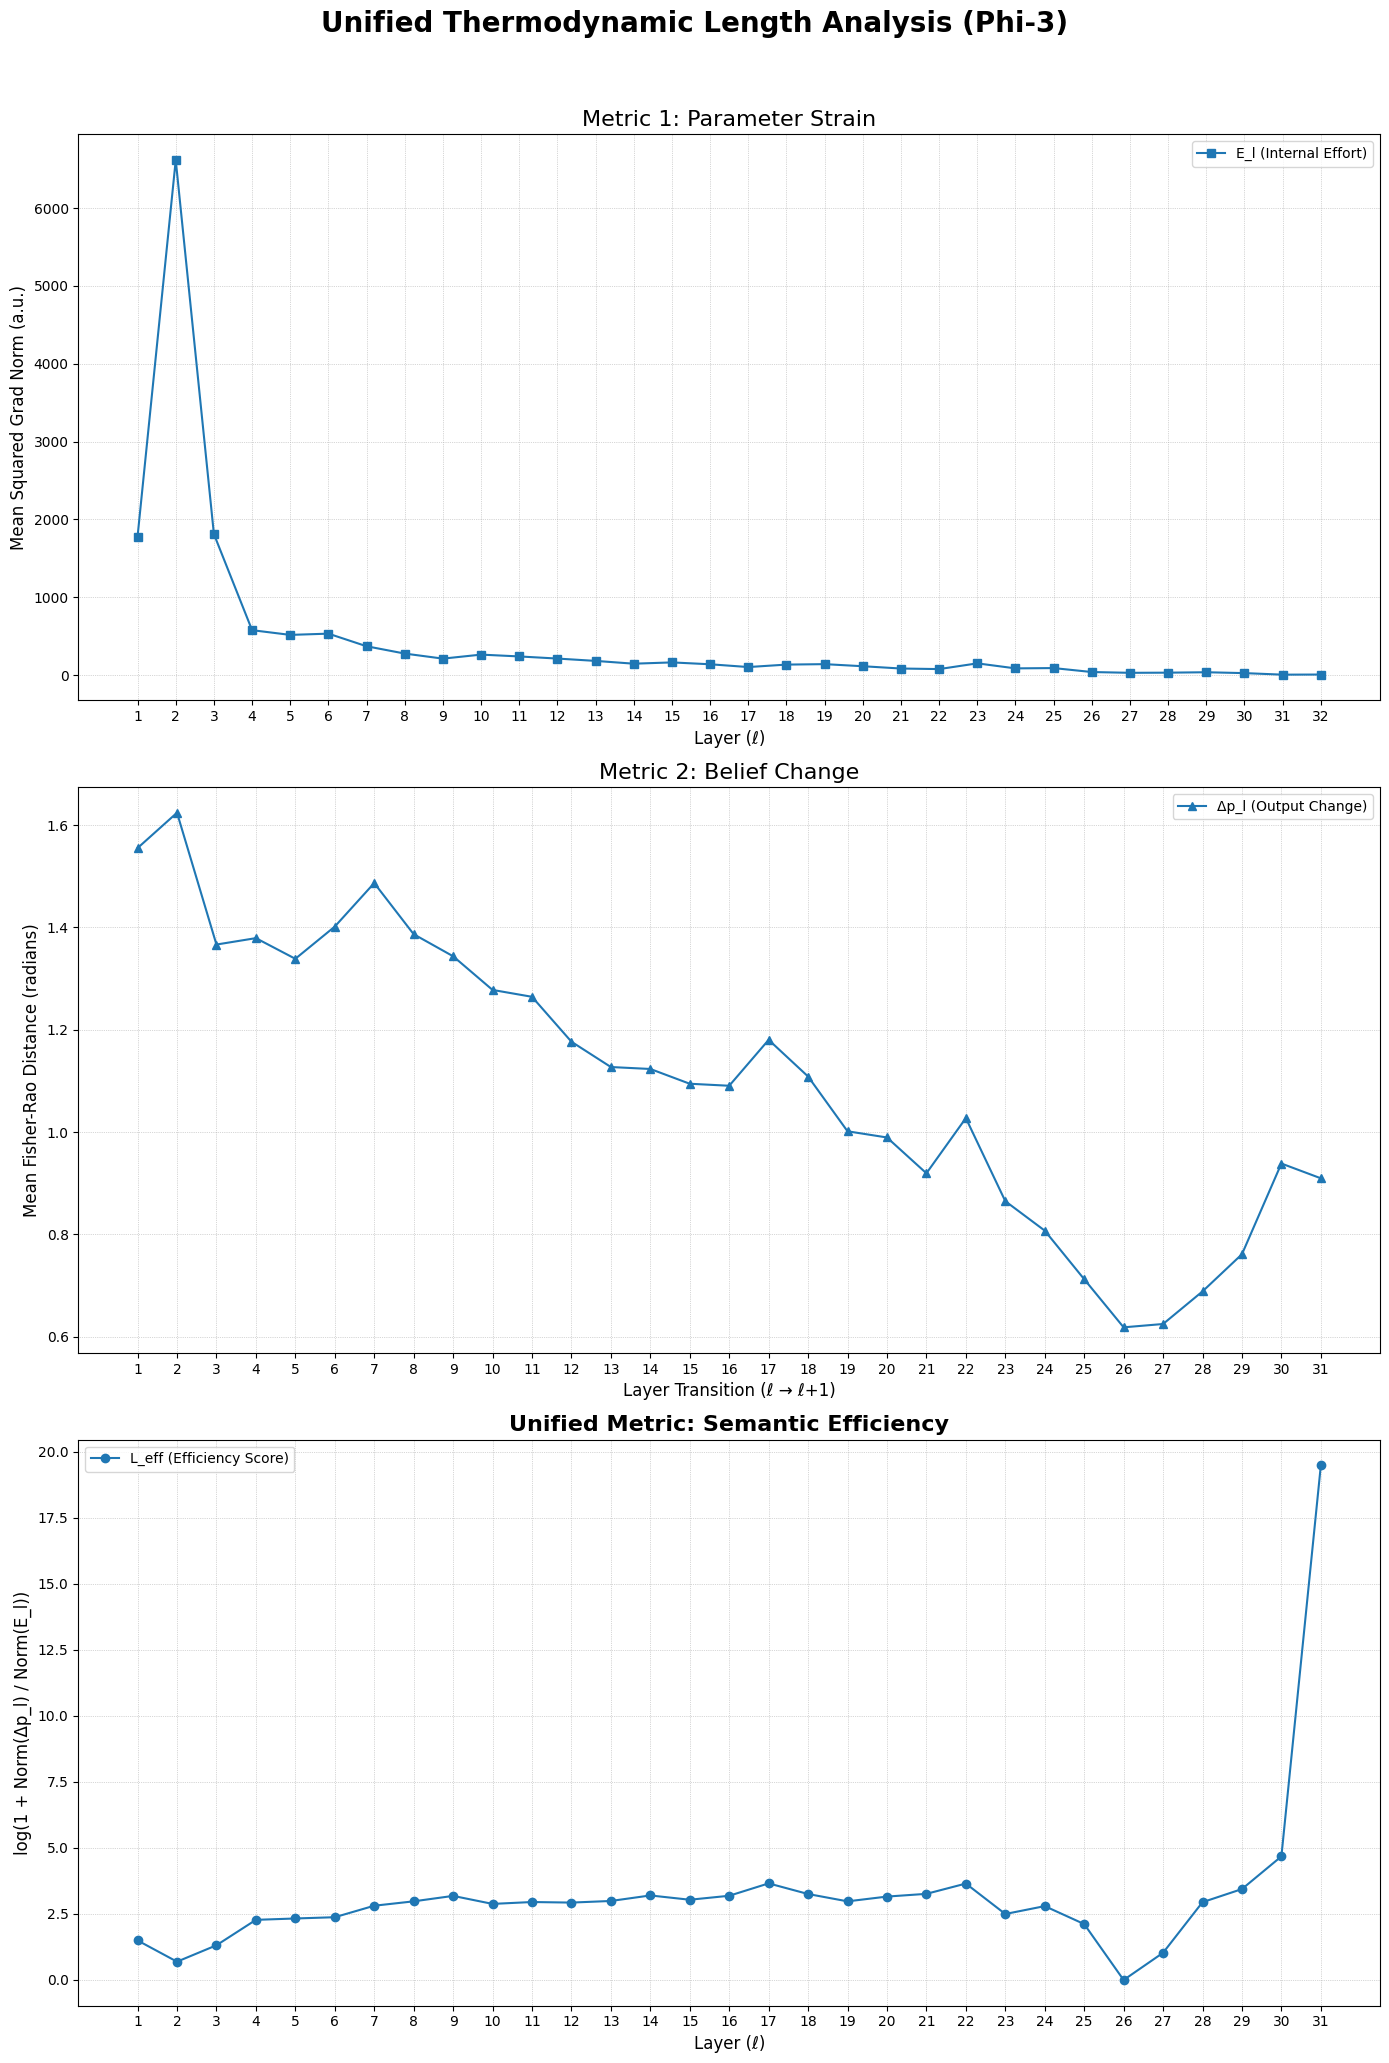


Phi-3 Thermodynamic Length Analysis Complete!


In [4]:
# %%
# Phi-3 version: per-layer individual backward to capture per-layer gradient contributions.
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
import math
import random

# -----------------------
# Config
# -----------------------
MODEL_NAME   = "microsoft/Phi-3-mini-4k-instruct"  # Updated to Phi-3
MAX_SAMPLES  = 200
BATCH_SIZE   = 2
MAX_SEQ_LEN  = 256
NUM_WORKERS  = 2
DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {DEVICE}")

SEED = 4242
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if DEVICE == "cuda":
    torch.cuda.manual_seed_all(SEED)

if DEVICE == "cuda":
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    try:
        torch.set_float32_matmul_precision("high")
    except Exception:
        pass

print(f"Loading model: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True, trust_remote_code=True)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME, 
    torch_dtype=torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16,
    trust_remote_code=True
)
model.eval().to(DEVICE)

# Phi-3 architecture access
transformer = model.model  # Phi-3 uses 'model' instead of 'transformer'
blocks = transformer.layers  # Phi-3 uses 'layers' instead of 'h'
final_ln = transformer.norm  # Phi-3 uses 'norm' instead of 'ln_f'
lm_head = model.lm_head

num_layers = len(blocks)
print(f"Model has {num_layers} decoder blocks")

# -----------------------
# Load SQuAD (train) and prepare dataset
# -----------------------
print("Loading SQuAD (train)...")
ds = load_dataset("squad", split="train")

def build_text(example):
    q = example["question"].strip().replace("\n", " ")
    c = example["context"].strip().replace("\n", " ")
    # Use Phi-3's instruction format
    return f"<|user|>\nQuestion: {q}\nContext: {c}\nWhat is the answer?<|end|>\n<|assistant|>\n"

ds = ds.map(lambda ex: {"text": build_text(ex)}, remove_columns=ds.column_names)
ds = ds.filter(lambda ex: len(ex["text"]) > 50)
if MAX_SAMPLES is not None:
    ds = ds.select(range(min(MAX_SAMPLES, len(ds))))

print(f"Dataset size after filtering/select: {len(ds)} rows")
print("\nSample prompt:")
print(ds[0]["text"][:400], " ...")

# -----------------------
# Collate function (same teacher-forcing shift)
# -----------------------
def causal_collate(batch):
    texts = [ex["text"] for ex in batch]
    tok = tokenizer(
        texts,
        padding="longest",
        truncation=True,
        max_length=MAX_SEQ_LEN,
        return_tensors="pt",
    )
    input_ids = tok["input_ids"]
    attention_mask = tok["attention_mask"]

    input_ids_shifted  = input_ids[:, :-1].contiguous()
    attention_shifted  = attention_mask[:, :-1].contiguous()
    labels_shifted     = input_ids[:, 1:].contiguous()
    labels_shifted = labels_shifted.masked_fill(attention_mask[:, 1:] == 0, -100)

    batch = {
        "input_ids": input_ids_shifted,
        "labels": labels_shifted,
        "attention_mask": attention_shifted,
    }
    return batch

loader = DataLoader(
    ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=causal_collate,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

# -----------------------
# Helper function to create 4D attention mask for Phi-3
# -----------------------
def create_phi3_attention_mask(attention_mask_2d, dtype):
    """Convert 2D attention mask to 4D causal mask for Phi-3"""
    B, S = attention_mask_2d.shape
    device = attention_mask_2d.device
    
    # Create 4D mask: (batch_size, 1, seq_len, seq_len)
    attention_mask_4d = attention_mask_2d.unsqueeze(1).unsqueeze(2).expand(B, 1, S, S)
    
    # Create causal mask (lower triangular)
    causal_mask = torch.tril(torch.ones(S, S, device=device, dtype=torch.bool))
    
    # Combine padding mask with causal mask - keep as boolean
    attention_mask_4d = attention_mask_4d.bool() & causal_mask.unsqueeze(0).unsqueeze(0)
    
    # Convert to proper format: 0 for attend, large negative for mask
    attention_mask_4d = torch.where(attention_mask_4d, 0.0, torch.finfo(dtype).min).to(dtype)
    
    return attention_mask_4d

# -----------------------
# Phi-3: per-layer individual backward
# -----------------------
layer_grad_sums = torch.zeros(num_layers, device=DEVICE)  # accumulate per-layer ||grad||^2
num_batches = 0

print("\nStarting per-layer effort computation (Phi-3 style) ...")
amp_dtype = torch.bfloat16 if (DEVICE=="cuda" and torch.cuda.is_bf16_supported()) else torch.float16

for batch in tqdm(loader, total=math.ceil(len(ds)/BATCH_SIZE)):
    num_batches += 1
    input_ids = batch["input_ids"].to(DEVICE, non_blocking=True)
    labels    = batch["labels"].to(DEVICE, non_blocking=True)
    attention_mask = batch["attention_mask"].to(DEVICE, non_blocking=True)
    B, S = input_ids.shape

    # Build initial embeddings and create proper masks for Phi-3
    with torch.autocast(device_type="cuda", dtype=amp_dtype, enabled=(DEVICE=="cuda")):
        # Create position IDs for Phi-3
        position_ids = torch.arange(S, dtype=torch.long, device=DEVICE).unsqueeze(0).expand(B, S)
        
        # Create 4D attention mask for Phi-3
        attention_mask_4d = create_phi3_attention_mask(attention_mask, amp_dtype)
        
        # Phi-3 embedding
        h = transformer.embed_tokens(input_ids)
        
        # Apply dropout if present
        if hasattr(transformer, 'embed_dropout'):
            h = transformer.embed_dropout(h)

    # We'll forward layer-by-layer, but for Phi-3 we compute gradient per-layer separately.
    for ell in range(num_layers):
        # Isolate incoming hidden to this block so backpropagation from this block's loss
        # only affects parameters reachable from this block's computation (Phi-3 isolation).
        h_prev = h.detach()  # detach to isolate gradients for current block

        with torch.autocast(device_type="cuda", dtype=amp_dtype, enabled=(DEVICE=="cuda")):
            # Phi-3 layer forward pass with position_ids and 4D attention mask
            h_ell = blocks[ell](h_prev, attention_mask=attention_mask_4d, position_ids=position_ids)[0]
            logits_ell = lm_head(final_ln(h_ell))

            # Cross-entropy on teacher-forced next-token targets
            loss_ell = F.cross_entropy(
                logits_ell.view(-1, logits_ell.size(-1)),
                labels.view(-1),
                ignore_index=-100,
                reduction="mean",
            )

        # --- Compute gradients for this layer's loss only (Phi-3): backward, accumulate grad norms, zero grads ---
        model.zero_grad(set_to_none=True)
        loss_ell.backward()

        with torch.no_grad():
            g2 = torch.tensor(0.0, device=DEVICE)
            for p in blocks[ell].parameters():
                if p.grad is not None:
                    g2 += (p.grad.detach() ** 2).sum()
            layer_grad_sums[ell] += g2

        # zero grads before next layer's backward pass
        model.zero_grad(set_to_none=True)

        # advance hidden state for next block
        h = h_ell

# Results: mean over batches
layer_grad_sums_cpu = layer_grad_sums.detach().cpu().numpy()
mean_layer_grad_sq = layer_grad_sums_cpu / max(1, num_batches)

print("\n--- Per-layer squared gradient norms (mean over batches) [Phi-3] ---")
for i, val in enumerate(mean_layer_grad_sq, start=1):
    print(f"Layer {i:2d}: {val: .6e}")

# Plot per-layer gradient norms
plt.figure(figsize=(12,6))
plt.plot(range(1, num_layers+1), mean_layer_grad_sq, marker='o')
plt.title(f'Phi-3 Per-layer Squared Grad Norm — {MODEL_NAME} (SQuAD prompts)')
plt.xlabel('Layer index (1 = lowest)')
plt.ylabel('Mean squared grad norm (a.u.)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# -----------------------
# Fisher–Rao thermodynamic length from predictions (unchanged)
# -----------------------
num_steps = len(blocks) - 1
fr_step_sums   = torch.zeros(num_steps, device=DEVICE)
fr_step_counts = torch.zeros(num_steps, device=DEVICE)

print("\nComputing Thermodynamic Length from predictions (Fisher–Rao, exact) ...")

@torch.no_grad()
def fr_step_from_logprobs(logp_prev, logp_next, valid_mask):
    s = 0.5 * (logp_prev + logp_next)
    log_bc = torch.logsumexp(s, dim=-1)
    bc = torch.exp(log_bc)
    bc = bc.clamp_(0.0, 1.0)
    steps = 2.0 * torch.acos(bc)
    if valid_mask is not None:
        steps = steps.masked_fill(~valid_mask, 0.0)
    return steps

# Iterate again for FR (teacher-forced)
for batch in tqdm(loader, total=math.ceil(len(loader.dataset)/loader.batch_size)):
    input_ids = batch["input_ids"].to(DEVICE, non_blocking=True)
    labels    = batch["labels"].to(DEVICE, non_blocking=True)
    attention_mask = batch["attention_mask"].to(DEVICE, non_blocking=True)
    B, S = input_ids.shape

    with torch.autocast(device_type="cuda", dtype=amp_dtype, enabled=(DEVICE=="cuda")):
        # Create position IDs for Phi-3
        position_ids = torch.arange(S, dtype=torch.long, device=DEVICE).unsqueeze(0).expand(B, S)
        
        # Create 4D attention mask for Phi-3
        attention_mask_4d = create_phi3_attention_mask(attention_mask, amp_dtype)
        
        # Phi-3 embedding
        h = transformer.embed_tokens(input_ids)
        
        # Apply dropout if present
        if hasattr(transformer, 'embed_dropout'):
            h = transformer.embed_dropout(h)

    logp_prev = None

    for ell in range(len(blocks)):
        with torch.autocast(device_type="cuda", dtype=amp_dtype, enabled=(DEVICE=="cuda")):
            h = blocks[ell](h, attention_mask=attention_mask_4d, position_ids=position_ids)[0]
            logits = lm_head(final_ln(h))

        logp = F.log_softmax(logits.float(), dim=-1)

        if logp_prev is not None:
            valid = (labels != -100)
            steps = fr_step_from_logprobs(logp_prev, logp, valid)
            step_idx = ell - 1
            fr_step_sums[step_idx]   += steps.sum()
            fr_step_counts[step_idx] += valid.sum()

        logp_prev = logp

fr_step_means = (fr_step_sums / fr_step_counts.clamp_min(1)).detach().cpu().numpy()

print("\n--- Fisher–Rao Thermodynamic Length from predictions (per inter-layer step) ---")
for k, val in enumerate(fr_step_means, start=1):
    print(f"Between layers {k:2d} and {k+1:2d}: {val:.6e} rad")

plt.figure(figsize=(12, 6))
x = np.arange(1, num_steps+1)
plt.plot(x, fr_step_means, marker='o')
plt.title(f'Fisher–Rao Thermodynamic Length (exact) — {MODEL_NAME} on SQuAD\nPer-step: between layer $\\ell$ and $\\ell{{+}}1$')
plt.xlabel('Inter-layer step (ℓ → ℓ+1)')
plt.ylabel('Mean FR step length (radians)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# -----------------------
# Merge: Semantic Efficiency (unchanged logic)
# -----------------------
raw_belief_change = np.array(fr_step_means)  # length num_layers - 1
raw_param_strain = np.array(mean_layer_grad_sq)  # length num_layers

# Align sizes (pair step ℓ→ℓ+1 with strain at layer ℓ)
param_strain_matched = raw_param_strain[:len(raw_belief_change)]

EPSILON = 1e-9
def min_max_scale(x):
    return (x - x.min()) / (x.max() - x.min() + EPSILON)

norm_param_strain = min_max_scale(param_strain_matched)
norm_belief_change = min_max_scale(raw_belief_change)
semantic_efficiency = np.log(1 + norm_belief_change / (norm_param_strain + EPSILON))

# Print and plot (same plotting style)
print("\n--- Final Metrics (Phi-3) ---")
print(f"{'Layer':>5} | {'Param Strain (E_l)':>20} | {'Belief Change (Δp_l)':>22} | {'Semantic Efficiency (L_eff)':>28}")
print("-" * 85)
for i in range(len(semantic_efficiency)):
    print(f"{i+1:>5} | {param_strain_matched[i]:>20.4e} | {raw_belief_change[i]:>22.6e} | {semantic_efficiency[i]:>28.4f}")

plt.style.use('default')  # Changed from seaborn as it might not be available
fig, axes = plt.subplots(3, 1, figsize=(14, 21), sharex=False)
fig.suptitle('Unified Thermodynamic Length Analysis (Phi-3)', fontsize=20, fontweight='bold')

layer_indices_strain = range(1, len(raw_param_strain) + 1)
axes[0].plot(layer_indices_strain, raw_param_strain, marker='s', label='E_l (Internal Effort)')
axes[0].set_title('Metric 1: Parameter Strain', fontsize=16)
axes[0].set_ylabel('Mean Squared Grad Norm (a.u.)', fontsize=12)
axes[0].set_xlabel('Layer (ℓ)', fontsize=12)
axes[0].set_xticks(layer_indices_strain)
axes[0].legend()
axes[0].grid(True, which='both', linestyle=':', linewidth=0.5)

layer_indices_change = range(1, len(raw_belief_change) + 1)
axes[1].plot(layer_indices_change, raw_belief_change, marker='^', label='Δp_l (Output Change)')
axes[1].set_title('Metric 2: Belief Change', fontsize=16)
axes[1].set_ylabel('Mean Fisher-Rao Distance (radians)', fontsize=12)
axes[1].set_xlabel('Layer Transition (ℓ → ℓ+1)', fontsize=12)
axes[1].set_xticks(layer_indices_change)
axes[1].legend()
axes[1].grid(True, which='both', linestyle=':', linewidth=0.5)

layer_indices_eff = range(1, len(semantic_efficiency) + 1)
axes[2].plot(layer_indices_eff, semantic_efficiency, marker='o', label='L_eff (Efficiency Score)')
axes[2].set_title('Unified Metric: Semantic Efficiency', fontsize=16, fontweight='bold')
axes[2].set_ylabel('log(1 + Norm(Δp_l) / Norm(E_l))', fontsize=12)
axes[2].set_xlabel('Layer (ℓ)', fontsize=12)
axes[2].set_xticks(layer_indices_eff)
axes[2].legend()
axes[2].grid(True, which='both', linestyle=':', linewidth=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

print("\nPhi-3 Thermodynamic Length Analysis Complete!")